# 1. Library prep

In [142]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import eda
from model import make_confusion_matrix
import stanza_nlp as stnlp

# NLP stuff
# TODO: remove unnecessary imports
from nltk import ngrams, pos_tag
from nltk.corpus import names, stopwords, wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer, RegexpTokenizer, MWETokenizer
from nltk.cluster import cosine_distance, euclidean_distance
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.chunk import ne_chunk

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


# other string processing
import re
import string

# classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, BaseEnsemble
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration

# model selection and metric helpers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, fbeta_score, log_loss 
from sklearn.metrics import roc_auc_score, euclidean_distances, make_scorer, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from joblib import dump, load, parallel_backend
import os

RANDOM = 42

Run this if NLTK hasn't been set up locally

In [2]:
#import nltk
#nltk.download()

# 2. Data loading and initial inspection

From the README:

- Column 1: the ID of the statement ([ID].json).
- Column 2: the label.
- Column 3: the statement.
- Column 4: the subject(s).
- Column 5: the speaker.
- Column 6: the speaker's job title.
- Column 7: the state info.
- Column 8: the party affiliation.
- Column 9-13: the total credit history count, including the current statement.
  - 9: barely true counts.
  - 10: false counts.
  - 11: half true counts.
  - 12: mostly true counts.
  - 13: pants on fire counts.
- Column 14: the context (venue / location of the speech or statement).

In [3]:
# read the LIAR dataset

liar_credit_hist_headers = ['speaker_bt', 'speaker_f', 'speaker_ht', 'speaker_mt', 'speaker_pof']
liar_speaker_headers = ['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation'] + liar_credit_hist_headers
liar_column_headers = ['id', 'label', 'statement', 'subjects']  + liar_speaker_headers + ['context']

# read the pre-prepared training, validation and test sets

liar_train = pd.read_csv("./data/liar_dataset/train.tsv", sep='\t', names=liar_column_headers, index_col='id')
liar_valid = pd.read_csv("./data/liar_dataset/valid.tsv", sep='\t', names=liar_column_headers, index_col='id')
liar_test = pd.read_csv("./data/liar_dataset/test.tsv", sep='\t', names=liar_column_headers, index_col='id')

# we will use the validation set for model selection; the test set is to be left for judging the final model

liar_train

,label,statement,subjects,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof,context
id,,,,,,,,,,,,,
2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate


In [4]:
liar_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10240 entries, 2635.json to 1155.json
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                10240 non-null  object 
 1   statement            10240 non-null  object 
 2   subjects             10238 non-null  object 
 3   speaker              10238 non-null  object 
 4   speaker_job          7343 non-null   object 
 5   speaker_us_state     8032 non-null   object 
 6   speaker_affiliation  10238 non-null  object 
 7   speaker_bt           10238 non-null  float64
 8   speaker_f            10238 non-null  float64
 9   speaker_ht           10238 non-null  float64
 10  speaker_mt           10238 non-null  float64
 11  speaker_pof          10238 non-null  float64
 12  context              10138 non-null  object 
dtypes: float64(5), object(8)
memory usage: 1.1+ MB


In [5]:
liar_train.iloc[0]['statement']

'Says the Annies List political group supports third-trimester abortions on demand.'

Plot the truth values of the dataset

In [107]:
liar_label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

def liar_truthdist_subj(subj=None, ax=None, saveplot=True, longtitle=True):
    """
    Plots the truth distribution of the LIAR dataset, optionally by subject
    Return the dataframe representing the plot, and the seaborn plot obj
    """   
    if not ax:
        fig, ax = plt.subplots()

    if subj == None:
        subj_filter = liar_train['subjects'].apply(lambda x: True)
        plt_title = 'distribution of truth values'
        filename = './image/liar_truthvals_dist.png'
    else:
        subj_filter = liar_train['subject_list'].apply(lambda entry: subj in entry)
        if longtitle:
            plt_title = '"' + subj + '": distribution of truth values'
        else:
            plt_title = subj
        filename = './image/liar_truthvals_dist_' + subj + '.png'
    
    subj_truthdist = pd.DataFrame({'label': liar_label, 'count': label_count} 
                                  for liar_label, label_count 
                                  in zip(liar_label_order, liar_train[subj_filter]['label'].value_counts()))
    
    sns.barplot(data=subj_truthdist, y='label', x='count', palette='coolwarm', ax=ax).set(title=plt_title, xlabel='count')
    plt.tight_layout()

    if saveplot:
        plt.savefig(filename)

    return subj_truthdist, ax

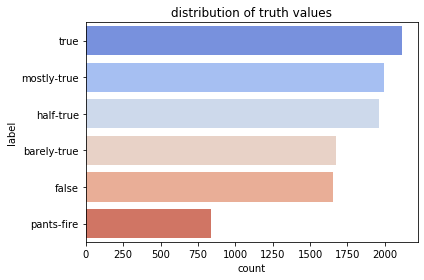

In [108]:
liar_train_truthval_dist, _ = liar_truthdist_subj()

We set up weights for future random forest training so that the labels are not so imbalanced

In [8]:
liar_train_truthval_weight = {
    label: liar_train_truthval_dist['count'].max() / count
    for label, count in zip(liar_train_truthval_dist['label'], liar_train_truthval_dist['count'])
}

liar_train_truthval_weight

{'true': 1.0,
 'mostly-true': 1.0596491228070175,
 'half-true': 1.0774719673802242,
 'barely-true': 1.2613365155131264,
 'false': 1.2781136638452237,
 'pants-fire': 2.5196662693682956}

In [9]:
liar_train['speaker_affiliation'].value_counts()

republican                      4497
democrat                        3336
none                            1744
organization                     219
independent                      147
newsmaker                         56
libertarian                       40
activist                          39
journalist                        38
columnist                         35
talk-show-host                    26
state-official                    20
labor-leader                      11
tea-party-member                  10
business-leader                    9
green                              3
education-official                 2
Moderate                           1
democratic-farmer-labor            1
constitution-party                 1
government-body                    1
liberal-party-canada               1
ocean-state-tea-party-action       1
Name: speaker_affiliation, dtype: int64

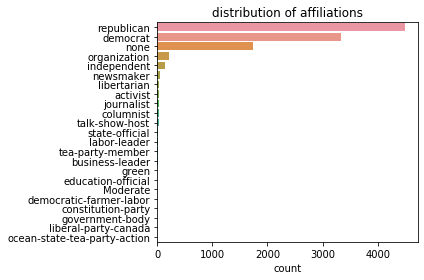

In [10]:
sns.barplot(y=liar_train['speaker_affiliation'].value_counts().index, x=liar_train['speaker_affiliation'].value_counts()).set(title='distribution of affiliations', xlabel='count')
plt.tight_layout()
plt.savefig('./image/liar_affiliations_dist.png');

In [11]:
liar_speakers_full = liar_train[liar_speaker_headers]

liar_speakers = liar_speakers_full.drop_duplicates().sort_values(by='speaker')
#liar_speakers['count_in_set'] = liar_speakers_full.groupby(liar_speaker_headers, as_index=False).size().values

liar_speakers['speaker'].value_counts()

#liar_speakers_full.groupby('speaker', as_index=False).size()

danny-tarkanian              2
kasim-reed                   2
robert-puente                2
dennis-ross                  1
dan-saltzman                 1
                            ..
lloyd-doggett                1
paul-doughty                 1
jeff-cogen                   1
al-roker                     1
clayton-county-government    1
Name: speaker, Length: 2910, dtype: int64

There are inconsistent entries for three speakers, probably because of incomplete data entry

In [12]:
liar_train[liar_train['speaker']=='kasim-reed'][liar_speaker_headers].drop_duplicates()

,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof
id,,,,,,,,,
4659.json,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0
13163.json,kasim-reed,Atlanta Mayor,Georgia,democrat,0.0,0.0,1.0,0.0,0.0


In [13]:
liar_train[liar_train['speaker']=='danny-tarkanian'][liar_speaker_headers].drop_duplicates()

,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof
id,,,,,,,,,
1815.json,danny-tarkanian,Businessman,Nevada,republican,0.0,0.0,0.0,1.0,0.0
12280.json,danny-tarkanian,NaN,Nevada,republican,1.0,0.0,1.0,0.0,0.0


In [14]:
liar_train[liar_train['speaker']=='robert-puente'][liar_speaker_headers].drop_duplicates()

,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof
id,,,,,,,,,
10887.json,robert-puente,NaN,NaN,none,0.0,0.0,1.0,0.0,0.0
8784.json,robert-puente,"CEO, San Antonio Water System",Texas,democrat,0.0,1.0,0.0,0.0,0.0


Let's overwrite the NaN with the actual values

In [15]:
liar_train['speaker_affiliation'].mask(liar_train['speaker_affiliation'] == 'none', inplace=True)

In [16]:
for speaker in ['danny-tarkanian', 'kasim-reed', 'robert-puente']:
    liar_train.loc[liar_train['speaker']==speaker, liar_speaker_headers] = \
        liar_train.loc[liar_train['speaker']==speaker, liar_speaker_headers].fillna(method='bfill')
    liar_train.loc[liar_train['speaker']==speaker, liar_speaker_headers] = \
        liar_train.loc[liar_train['speaker']==speaker, liar_speaker_headers].fillna(method='ffill')

We don't need the counts for individual speaker truth values, especially when there's no date attached, so let's ignore them.

It also appears that Politifact no longer has a public API, so scraping would need to be done instead; let's not bother pulling the associated dates then.

Need to convert subjects column into a list

In [111]:
liar_train['subject_list'] = liar_train['subjects'].apply(lambda s: str(s).lower().split(','))
liar_valid['subject_list'] = liar_valid['subjects'].apply(lambda s: str(s).lower().split(','))
liar_test['subject_list'] = liar_test['subjects'].apply(lambda s: str(s).lower().split(','))

liar_train_subj_dummies = eda.createdummy_from_listentries(liar_train, 'subject_list')

liar_train_subj_dummies

,abc-news-week,abortion,afghanistan,after-the-fact,agriculture,alcohol,animals,autism,bankruptcy,baseball,...,unions,urban,veterans,voting-record,water,wealth,weather,welfare,women,workers
id,,,,,,,,,,,,,,,,,,,,,
2635.json,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10540.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9028.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473.json,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3408.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3959.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
LIAR_SUBJ_THRESHOLD = 200

liar_train_subj_summary = pd.DataFrame(data=liar_train_subj_dummies.sum(), 
                                       columns=['count']).sort_values(by='count', 
                                                                      ascending=False)
liar_train_subj_summary['is_minor'] = liar_train_subj_summary['count'] < LIAR_SUBJ_THRESHOLD

liar_train_subj_summary

,count,is_minor
economy,893,False
health-care,741,False
candidates-biography,598,False
education,544,False
elections,431,False
...,...,...
nan,2,True
urban,1,True
death-penalty,1,True
fires,1,True


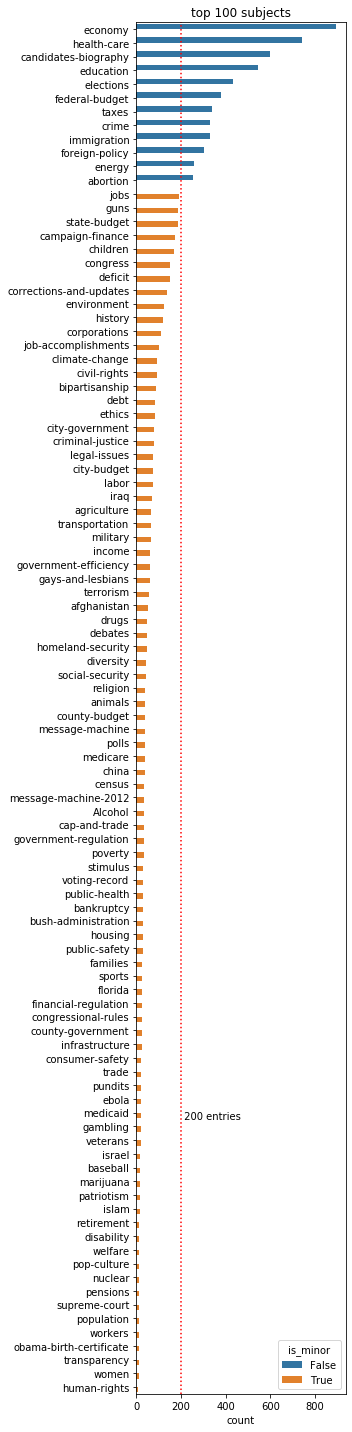

In [19]:
LIAR_SUBJ_COUNT_PLOTTED = 100

fig, ax = plt.subplots(figsize=(5,20))

sns.barplot(x=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED)['count'], y=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED).index, ax=ax, hue=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED)['is_minor']).set(title='top ' + str(LIAR_SUBJ_COUNT_PLOTTED) + ' subjects')
plt.axvline(LIAR_SUBJ_THRESHOLD, color='red', linestyle=':')
plt.text(LIAR_SUBJ_THRESHOLD, 0.2, " " + str(LIAR_SUBJ_THRESHOLD) + " entries", transform=ax.get_xaxis_transform())
plt.tight_layout()
plt.savefig('./image/liar_subj_dist_top100.png');

(         label  count
 0         true     11
 1  mostly-true      6
 2    half-true      5
 3  barely-true      4
 4        false      4
 5   pants-fire      3,
 <matplotlib.axes._subplots.AxesSubplot at 0x206e2fadb48>)

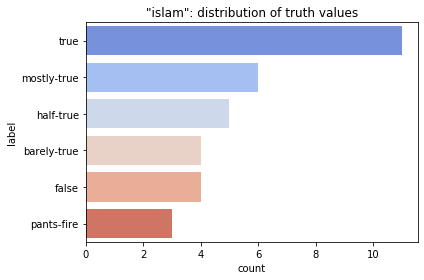

In [20]:
liar_truthdist_subj('islam')

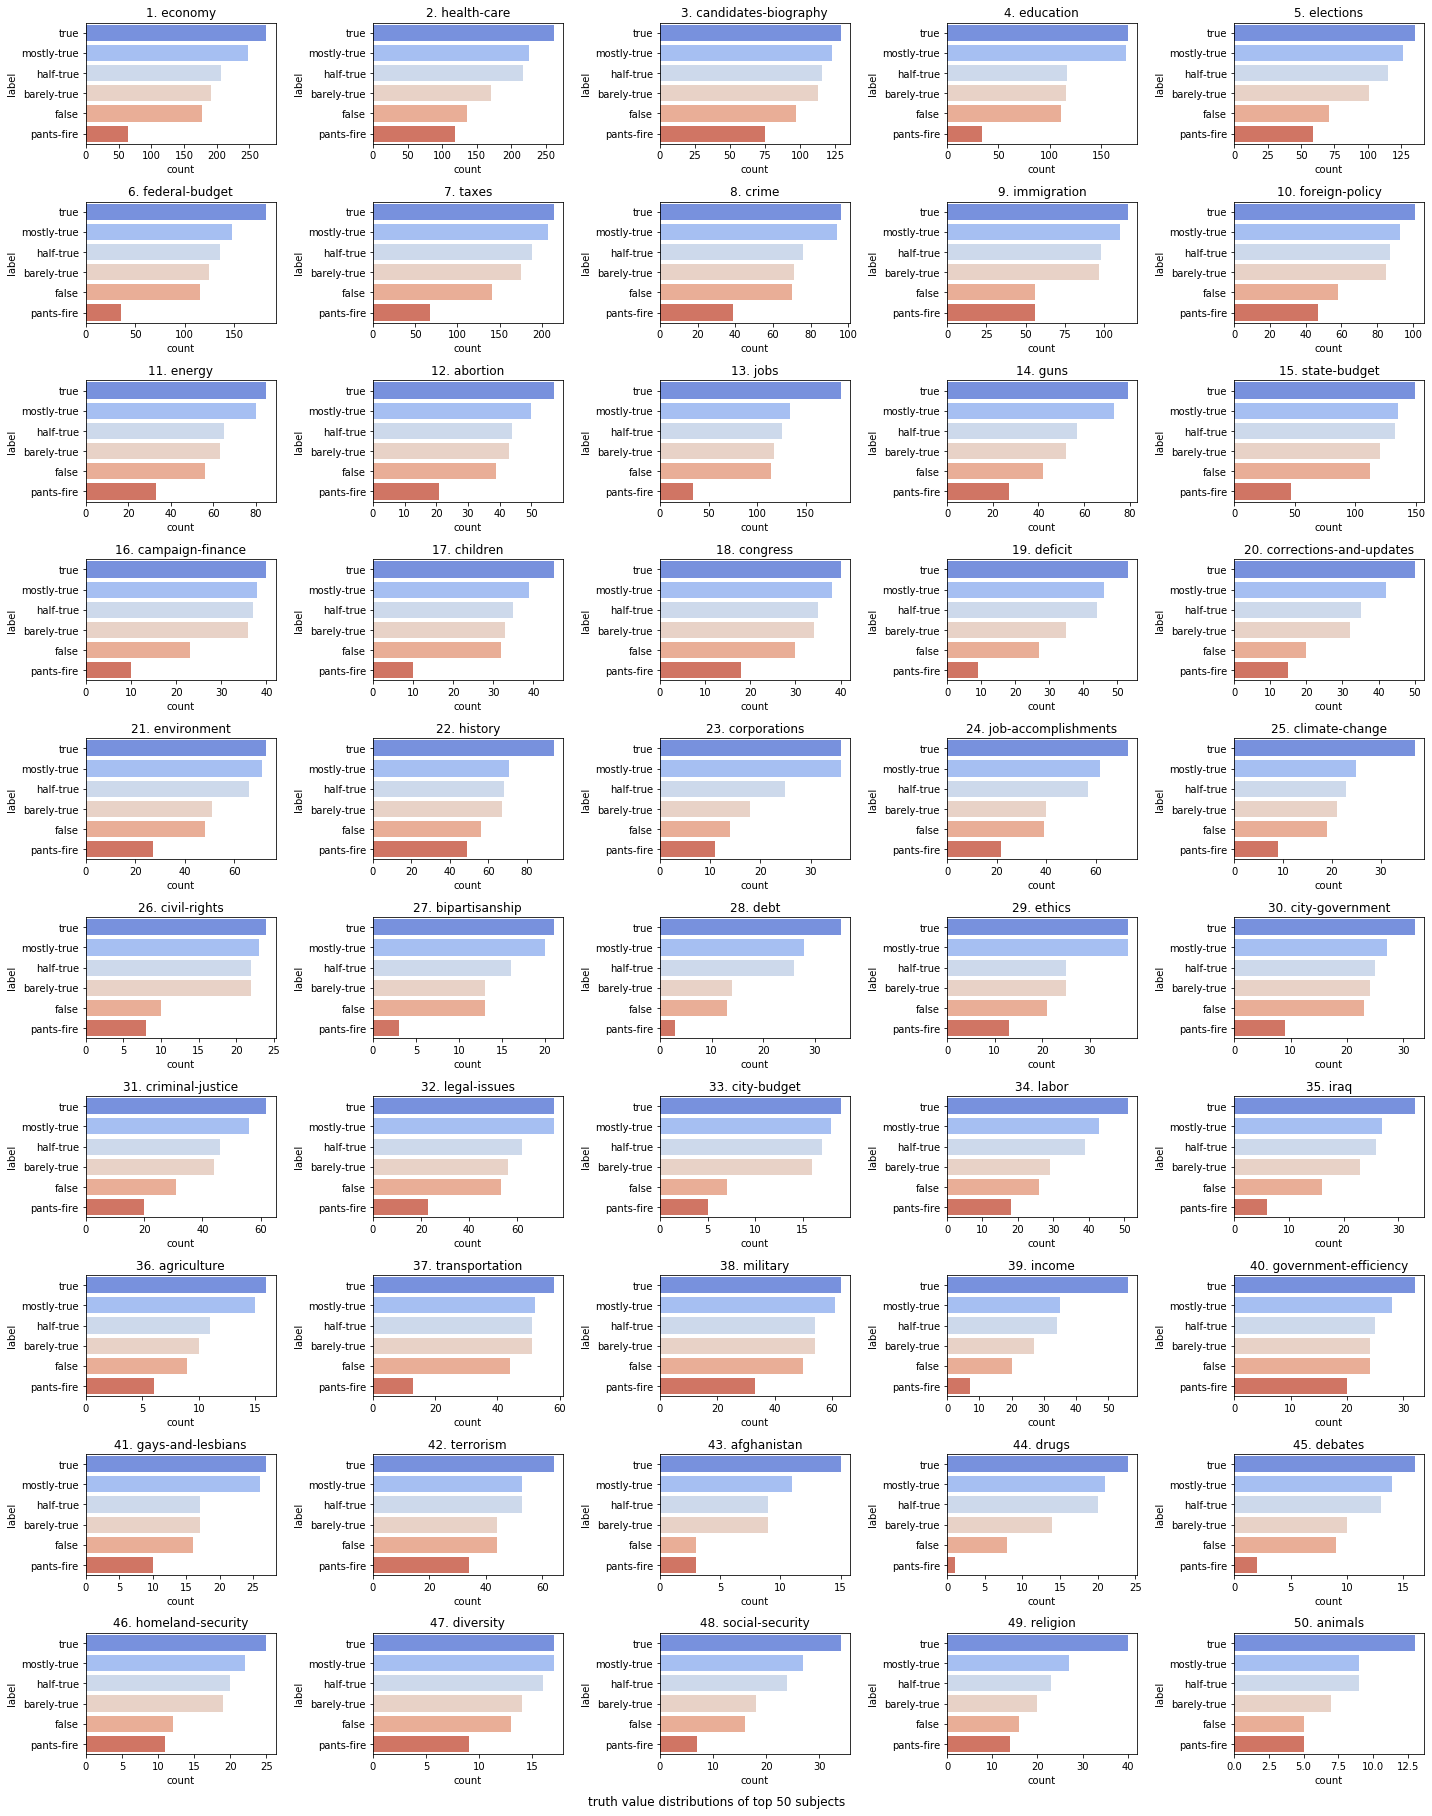

In [21]:
num_figs = 50
fig = plt.figure(figsize=(20,25))

for counter, subj in zip(range(0,num_figs), liar_train_subj_summary.index):
    ax = plt.subplot(10, 5, counter + 1)
    _ = liar_truthdist_subj(subj, ax=ax, saveplot=False)
    ax.set(title=str(counter + 1) + ". " + subj)

fig.suptitle('truth value distributions of top ' + str(num_figs) + ' subjects').set_y(0)

plt.tight_layout()
plt.savefig('./image/liar_top50_truthvals_dist.png')

In [22]:
# join truth value label to dummy col
liar_train_truthval = liar_train_subj_dummies.join(liar_train['label'])

# map summation of dummy vals based on index (which is subj)
for truth_value in liar_label_order:
    liar_train_subj_summary[truth_value] = liar_train_subj_summary.index.map(
        lambda x: liar_train_truthval[liar_train_truthval['label'] == truth_value][x].sum()
    )

liar_train_subj_summary

,count,is_minor,true,mostly-true,half-true,barely-true,false,pants-fire
economy,893,False,165,183,221,139,139,46
health-care,741,False,97,108,140,134,177,85
candidates-biography,598,False,90,111,106,101,120,70
education,544,False,93,131,128,83,84,25
elections,431,False,87,81,67,56,89,51
...,...,...,...,...,...,...,...,...
nan,2,True,0,0,0,0,2,0
fires,1,True,0,0,1,0,0,0
death-penalty,1,True,1,0,0,0,0,0
urban,1,True,1,0,0,0,0,0


In [23]:
def stacked_plot(df, cats, stack_cat_label='category', cat_axis='y', stack_cat=None, stack_cat_palette='coolwarm'):
    
    cat_colors = sns.color_palette(palette=stack_cat_palette, n_colors=len(stack_cat))
      
    #define start points for each stack of bar plot
    start_pts = [np.array([0] * len(cats))]
    for cat in stack_cat:
        start_pts.append(start_pts[-1] + np.array(df[cat]))
    start_pts.pop()

    # draw last cat first, we're layering bar plots on top of each other
    for cat, cat_color, start_pt in zip(reversed(stack_cat), reversed(cat_colors), reversed(start_pts)):
        if cat_axis == 'y':
            sns.barplot(y=cats, x=df[cat] + start_pt, color=cat_color, label=cat)
        else:
            sns.barplot(x=cats, y=df[cat] + start_pt, color=cat_color, label=cat)
    
    if cat_axis == 'y':
        plt.xlabel(stack_cat_label)
    else:
        plt.ylabel(stack_cat_label)
    
    plt.legend();

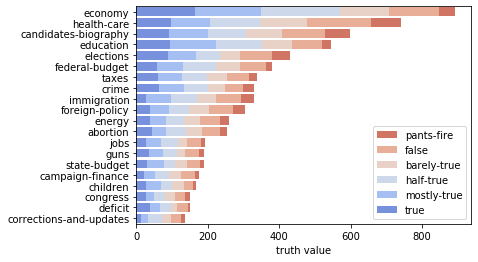

In [24]:
stacked_plot(liar_train_subj_summary.head(20), 
             liar_train_subj_summary.head(20).index, 
             stack_cat_label='truth value', 
             stack_cat=liar_label_order)
plt.savefig('./image/liar_subj_dist_top20_truthval_stacked.png')

# Classification w/o NLP

## Take 1: most features in, random forest

Using only select speaker features and subjects; ignoring the cumulative truth values as they could be from any time period

In [25]:
# initialise the cat encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [26]:
enc.fit(liar_train[['speaker']].fillna(''))
enc.transform(liar_train[['speaker']].fillna(''))

<10240x2911 sparse matrix of type '<class 'numpy.float64'>'
	with 10240 stored elements in Compressed Sparse Row format>

There are ~2.9k unique 'speakers'

In [27]:
enc.fit(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))
enc.transform(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))

<10240x4204 sparse matrix of type '<class 'numpy.float64'>'
	with 40960 stored elements in Compressed Sparse Row format>

Adding the other speaker features adds about 1.3k features

In [340]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))
speaker_dummies = enc.transform(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))
speaker_dummies_df = pd.DataFrame(data=speaker_dummies, 
                       index=liar_train.index, 
                       columns=enc.get_feature_names())

train_X = speaker_dummies_df.join(liar_train_subj_dummies).fillna('')
train_y = liar_train['label']

train_X, train_y

(            x0_  x0_18-percent-american-public  x0_60-plus-association  \
 id                                                                       
 2635.json   0.0                            0.0                     0.0   
 10540.json  0.0                            0.0                     0.0   
 324.json    0.0                            0.0                     0.0   
 1123.json   0.0                            0.0                     0.0   
 9028.json   0.0                            0.0                     0.0   
 ...         ...                            ...                     ...   
 5473.json   0.0                            0.0                     0.0   
 3408.json   0.0                            0.0                     0.0   
 3959.json   0.0                            0.0                     0.0   
 2253.json   0.0                            0.0                     0.0   
 1155.json   0.0                            0.0                     0.0   
 
             x0_AARP  x

Use the default random forest to do feature importance selection

In [29]:
feature_sel_rforest = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

feature_sel_rforest.fit(train_X, train_y)

feature_rank_df = pd.DataFrame()
feature_rank_df['feature'] = train_X.columns
feature_rank_df['importance'] = feature_sel_rforest.feature_importances_

In [30]:
feature_rank_df.sort_values('importance', ascending=False).head(50)

,feature,importance
4218,candidates-biography,0.014852
4244,economy,0.014729
4266,health-care,0.013161
4252,federal-budget,0.013048
4246,elections,0.012927
4245,education,0.012313
4328,taxes,0.012144
4234,crime,0.010684
4206,abortion,0.009800
4273,immigration,0.009775


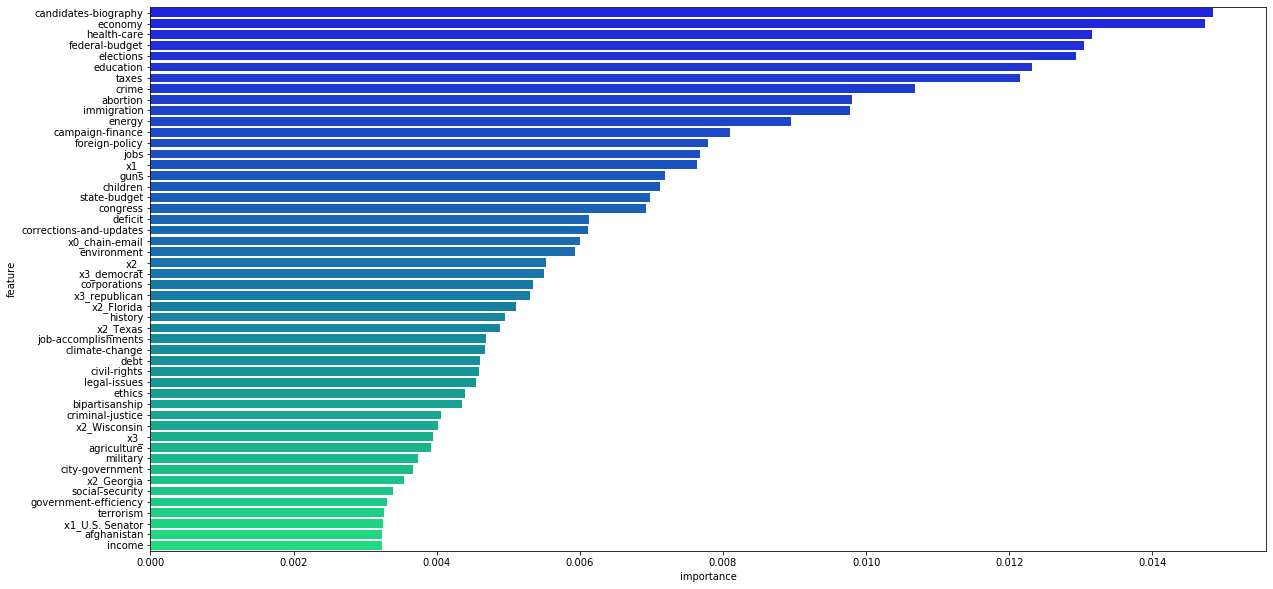

In [31]:
plt.figure(figsize=(20,10))
sns.barplot(data=feature_rank_df, x='importance', y='feature', order=feature_rank_df.sort_values('importance', ascending=False).head(50).feature, palette='winter')
plt.savefig("image/rforest_feature_importance.png");

It appears that the speaker features are not very predictive compared to subjects.  What about random forest performance?

In [32]:
model_rforest = RandomForestClassifier(n_jobs=-1, 
                                       random_state=RANDOM,
                                       class_weight=liar_train_truthval_weight)

f1scorer = make_scorer(fbeta_score, beta=1, average='weighted')

#create a dictionary of all values we want to test for n_neighbors
# note: trying with no max_depth resulted in overfitting
param_grid = {  'n_estimators':         [5, 20, 40, 100, 250, 500], 
                'max_depth':            [5, 10, 20, 50, 100], 
                'min_samples_split':    [2, 3, 4]}

#use gridsearch to test all values for n_neighbors
model_rforest_rscv = RandomizedSearchCV(model_rforest, 
                                        param_grid, 
                                        cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), 
                                        scoring=f1scorer, 
                                        random_state=RANDOM, 
                                        n_iter=20)

#fit model to data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 40, 'min_samples_split': 4, 'max_depth': 100}

In [33]:
model_rforest_rscv.best_score_

0.21822557553725658

In [34]:
results_rforest_rscv = pd.DataFrame(model_rforest_rscv.cv_results_)

results_rforest_rscv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.301732,0.604693,0.162393,0.003818,250,2,20,"{'n_estimators': 250, 'min_samples_split': 2, ...",0.164614,0.166062,0.183190,0.177789,0.160212,0.170373,0.008652,10
1,3.674869,0.484400,0.167800,0.008034,250,2,10,"{'n_estimators': 250, 'min_samples_split': 2, ...",0.128761,0.119986,0.129636,0.147830,0.106621,0.126567,0.013472,13
2,1.425505,0.055849,0.159305,0.001680,20,2,50,"{'n_estimators': 20, 'min_samples_split': 2, '...",0.204479,0.210796,0.211209,0.225556,0.207455,0.211899,0.007253,4
3,8.132289,0.177351,0.165907,0.005481,250,4,50,"{'n_estimators': 250, 'min_samples_split': 4, ...",0.203757,0.213713,0.215615,0.222213,0.199446,0.210949,0.008250,6
4,0.727300,0.053071,0.161106,0.006681,5,2,5,"{'n_estimators': 5, 'min_samples_split': 2, 'm...",0.084323,0.095952,0.135848,0.103623,0.076223,0.099194,0.020603,19
5,1.073469,0.037544,0.162347,0.005967,40,3,10,"{'n_estimators': 40, 'min_samples_split': 3, '...",0.117408,0.124740,0.135831,0.138291,0.116438,0.126542,0.009090,14
6,2.315876,0.086194,0.160759,0.003666,100,2,20,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.167856,0.163390,0.183093,0.171236,0.162978,0.169711,0.007350,11
7,16.921156,0.833933,0.274722,0.010175,500,3,50,"{'n_estimators': 500, 'min_samples_split': 3, ...",0.203674,0.212202,0.222626,0.217413,0.204446,0.212072,0.007329,3
8,1.748444,0.086984,0.164303,0.005042,250,3,5,"{'n_estimators': 250, 'min_samples_split': 3, ...",0.103865,0.087405,0.108277,0.117423,0.094955,0.102385,0.010418,18
9,1.334843,0.043549,0.159433,0.002444,40,3,20,"{'n_estimators': 40, 'min_samples_split': 3, '...",0.156779,0.168641,0.186893,0.181000,0.163740,0.171410,0.011066,9


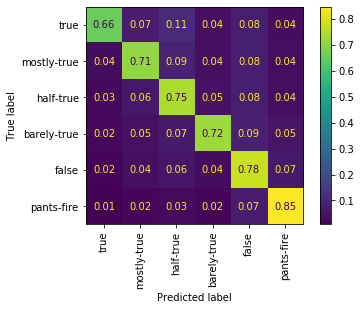

In [35]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Don't let the f1 score mislead you; the confusion matrix shows that it's actually done a pretty decent job!

Now let's try on the validation data

In [342]:
speaker_dummies_valid = enc.transform(
                    liar_valid[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna('')
                                    )
speaker_dummies_valid_df = pd.DataFrame(data=speaker_dummies_valid, 
                           index=liar_valid.index, 
                           columns=enc.get_feature_names())

liar_valid_subj_dummies = eda.createdummy_from_listentries(liar_valid, 'subject_list')

liar_valid_subj_notin_train = list(set(liar_valid_subj_dummies.columns).difference(set(liar_train_subj_dummies.columns)))
liar_train_subj_notin_valid = list(set(liar_train_subj_dummies.columns).difference(set(liar_valid_subj_dummies.columns)))

for col in liar_train_subj_notin_valid:
    liar_valid_subj_dummies[col] = 0
liar_valid_subj_dummies.drop(columns=liar_valid_subj_notin_train, inplace=True)
        

valid_X = speaker_dummies_valid_df.join(liar_valid_subj_dummies).fillna('')
valid_y = liar_valid['label']

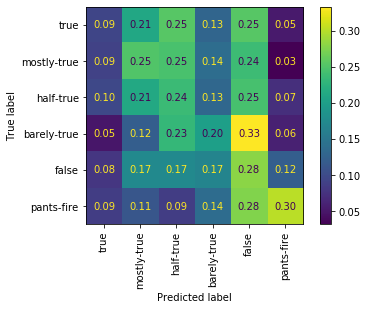

In [37]:
plot_confusion_matrix(model_rforest_rscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Performance is much worse, indicating overfitting.

## Take 2: just the subjects

In [38]:
train_X = liar_train_subj_dummies
train_y = liar_train['label']

train_X, train_y

(            Alcohol  abc-news-week  abortion  afghanistan  after-the-fact  \
 id                                                                          
 2635.json         0              0         1            0               0   
 10540.json        0              0         0            0               0   
 324.json          0              0         0            0               0   
 1123.json         0              0         0            0               0   
 9028.json         0              0         0            0               0   
 ...             ...            ...       ...          ...             ...   
 5473.json         0              0         0            0               0   
 3408.json         0              0         0            0               0   
 3959.json         0              0         0            0               0   
 2253.json         0              0         0            0               0   
 1155.json         0              0         0            0      

In [39]:
feature_sel_rforest.fit(train_X, train_y)

feature_rank_df = pd.DataFrame()
feature_rank_df['feature'] = train_X.columns
feature_rank_df['importance'] = feature_sel_rforest.feature_importances_

In [40]:
feature_rank_df.sort_values('importance', ascending=False).head(50)

,feature,importance
62,health-care,0.024358
110,religion,0.017987
40,economy,0.017743
78,labor,0.016285
41,education,0.014777
63,history,0.013891
27,corrections-and-updates,0.012934
42,elections,0.012905
86,message-machine,0.012791
69,immigration,0.012425


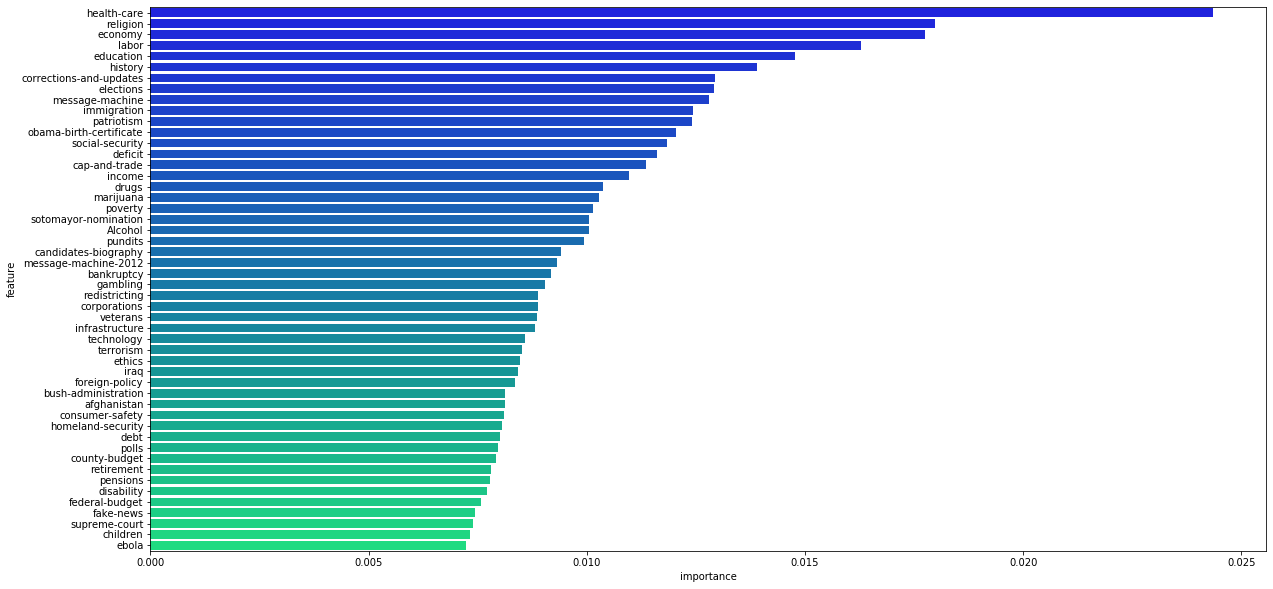

In [41]:
plt.figure(figsize=(20,10))
sns.barplot(data=feature_rank_df, x='importance', y='feature', order=feature_rank_df.sort_values('importance', ascending=False).head(50).feature, palette='winter')
plt.savefig("image/rforest_feature_importance_subjs_only.png");

In [42]:
liar_train_subj_summary.head(20).index

Index(['economy', 'health-care', 'candidates-biography', 'education',
       'elections', 'federal-budget', 'taxes', 'crime', 'immigration',
       'foreign-policy', 'energy', 'abortion', 'jobs', 'guns', 'state-budget',
       'campaign-finance', 'children', 'congress', 'deficit',
       'corrections-and-updates'],
      dtype='object')

In [43]:
list(feature_rank_df.sort_values('importance', ascending=False).head(20)['feature'])

['health-care',
 'religion',
 'economy',
 'labor',
 'education',
 'history',
 'corrections-and-updates',
 'elections',
 'message-machine',
 'immigration',
 'patriotism',
 'obama-birth-certificate',
 'social-security',
 'deficit',
 'cap-and-trade',
 'income',
 'drugs',
 'marijuana',
 'poverty',
 'sotomayor-nomination']

Top 20 subjects by count not the same as top 20 subjects by random forest feature importance

In [44]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 100}

In [45]:
model_rforest_rscv.best_score_

0.1709212650507964

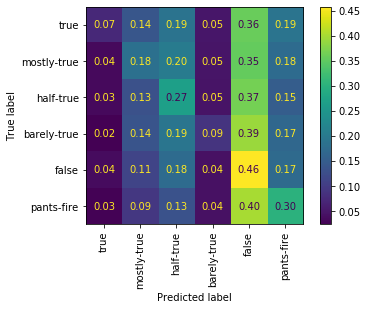

In [46]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Appears to be mostly predicting 'false', champion sitting-on-the-fence behaviour; 'pants-fire' is the second most prelevant prediction. What if we limit ourselves to top 20 subjects with the rest as others, and maybe put speaker affiliation back in?

## Take 3: limiting subjects, including speaker affiliations

Try top 20 most common subjects first

In [48]:
top20_subjs_bycount = list(liar_train_subj_summary.head(20).index)

In [49]:
train_X = liar_train_subj_dummies[top20_subjs_bycount]
train_y = liar_train['label']

train_X, train_y

(            economy  health-care  candidates-biography  education  elections  \
 id                                                                             
 2635.json         0            0                     0          0          0   
 10540.json        0            0                     0          0          0   
 324.json          0            0                     0          0          0   
 1123.json         0            1                     0          0          0   
 9028.json         1            0                     0          0          0   
 ...             ...          ...                   ...        ...        ...   
 5473.json         0            0                     0          0          0   
 3408.json         0            0                     0          0          1   
 3959.json         0            0                     0          0          0   
 2253.json         0            0                     0          0          0   
 1155.json         0        

In [50]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 40, 'min_samples_split': 3, 'max_depth': 20}

In [51]:
model_rforest_rscv.best_score_

0.14047482173108133

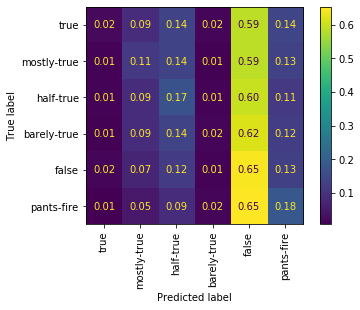

In [52]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Terrible performance, was mostly labelling statements as 'false'. What about by random forest feature importance?

In [54]:
top20_subjs_byimportance = list(feature_rank_df.sort_values('importance', ascending=False).head(20)['feature'])

In [55]:
train_X = liar_train_subj_dummies[top20_subjs_byimportance]
train_y = liar_train['label']

train_X, train_y

(            health-care  religion  economy  labor  education  history  \
 id                                                                      
 2635.json             0         0        0      0          0        0   
 10540.json            0         0        0      0          0        0   
 324.json              0         0        0      0          0        0   
 1123.json             1         0        0      0          0        0   
 9028.json             0         0        1      0          0        0   
 ...                 ...       ...      ...    ...        ...      ...   
 5473.json             0         0        0      0          0        0   
 3408.json             0         0        0      0          0        0   
 3959.json             0         0        0      0          0        0   
 2253.json             0         0        0      0          0        0   
 1155.json             1         0        0      0          0        0   
 
             corrections-and-updates

In [56]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 250, 'min_samples_split': 2, 'max_depth': 20}

In [57]:
model_rforest_rscv.best_score_

0.13045804497488428

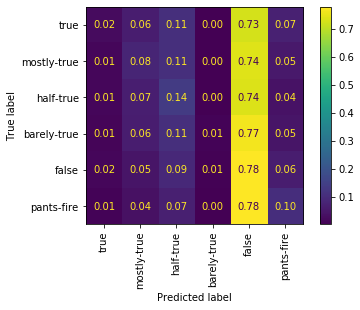

In [58]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Seems to be even worse in performance. So changing number of subjects doesn't seem helpful

What if we don't limit the subjects, and then add the speaker affiliation?

In [345]:
enc.fit(liar_train[['speaker_affiliation']].fillna(''))
speaker_aff_dummies = enc.transform(liar_train[['speaker_affiliation']].fillna(''))
speaker_aff_dummies_df = pd.DataFrame(data=speaker_aff_dummies, 
                                      index=liar_train.index, 
                                      columns=enc.get_feature_names())

train_X = speaker_aff_dummies_df.join(liar_train_subj_dummies).fillna('')
train_y = liar_train['label']

train_X, train_y

(            x0_  x0_Moderate  x0_activist  x0_business-leader  x0_columnist  \
 id                                                                            
 2635.json   0.0          0.0          0.0                 0.0           0.0   
 10540.json  0.0          0.0          0.0                 0.0           0.0   
 324.json    0.0          0.0          0.0                 0.0           0.0   
 1123.json   1.0          0.0          0.0                 0.0           0.0   
 9028.json   0.0          0.0          0.0                 0.0           0.0   
 ...         ...          ...          ...                 ...           ...   
 5473.json   1.0          0.0          0.0                 0.0           0.0   
 3408.json   0.0          0.0          0.0                 0.0           0.0   
 3959.json   0.0          0.0          0.0                 0.0           0.0   
 2253.json   0.0          0.0          0.0                 0.0           0.0   
 1155.json   0.0          0.0          0

In [61]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 40, 'min_samples_split': 4, 'max_depth': 100}

In [62]:
model_rforest_rscv.best_score_

0.19320215426469362

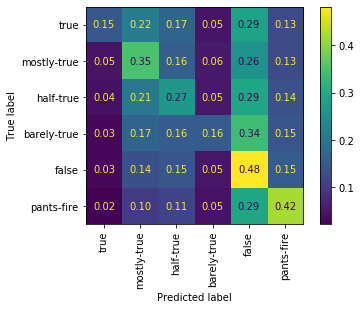

In [63]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Somewhat better performance that just subjects, but not by much

## Take 4: Make target trinery

In [64]:
train_y = liar_train['label'].replace('mostly-true', 'true').replace(['barely-true', 'pants-fire'], 'false')

train_y.value_counts()

false        4488
true         3638
half-true    2114
Name: label, dtype: int64

In [65]:
#Need to make a new set of weights for a new random forest model
liar_train_truthval_3_dist = pd.DataFrame({'label': liar_label, 'count': train_y.value_counts()[liar_label]} 
                                          for liar_label in ['true', 'half-true', 'false'])

liar_train_truthval_3_weight = {
    label: liar_train_truthval_3_dist['count'].max() / count
    for label, count in zip(liar_train_truthval_3_dist['label'], liar_train_truthval_3_dist['count'])
}

liar_train_truthval_3_weight

{'true': 1.233644859813084, 'half-true': 2.1229895931882687, 'false': 1.0}

In [66]:
#Now the new random forest model

model_rforest_3 = RandomForestClassifier(n_jobs=-1, 
                                         random_state=RANDOM,
                                         class_weight=liar_train_truthval_3_weight)

#use gridsearch to test all values for n_neighbors
model_rforest_3_rscv = RandomizedSearchCV(model_rforest_3, 
                                          param_grid, 
                                          cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), 
                                          scoring=f1scorer, 
                                          random_state=RANDOM, 
                                          n_iter=20)

#fit model to data
model_rforest_3_rscv.fit(train_X, train_y)
model_rforest_3_rscv.best_params_

{'n_estimators': 5, 'min_samples_split': 2, 'max_depth': 10}

In [67]:
model_rforest_3_rscv.best_score_

0.4300845499837783

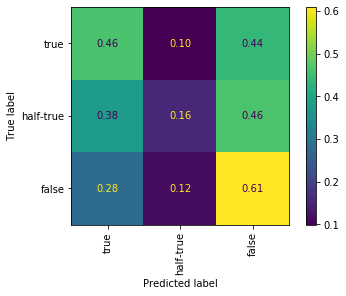

In [68]:
plot_confusion_matrix(model_rforest_3_rscv, train_X, train_y, 
                      labels=['true', 'half-true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Again, pretty terrible performance; half-true barely makes it. So let's try binary

In [69]:
train_y = liar_train['label'].replace('mostly-true', 'true').replace(['half-true', 'barely-true', 'pants-fire'], 'false')

train_y

id
2635.json     false
10540.json    false
324.json       true
1123.json     false
9028.json     false
              ...  
5473.json      true
3408.json      true
3959.json     false
2253.json     false
1155.json     false
Name: label, Length: 10240, dtype: object

In [70]:
#Need to make a new set of weights for a new random forest model
liar_train_truthval_2_dist = pd.DataFrame({'label': liar_label, 'count': label_count} 
                                          for liar_label, label_count 
                                          in zip(['true', 'false'], 
                                                 liar_train['label'].value_counts()))

liar_train_truthval_2_weight = {
    label: liar_train_truthval_2_dist['count'].max() / count
    for label, count in zip(liar_train_truthval_2_dist['label'], liar_train_truthval_2_dist['count'])
}

liar_train_truthval_2_weight

{'true': 1.0, 'false': 1.0596491228070175}

In [71]:
#Now the new random forest model

model_rforest_2 = RandomForestClassifier(n_jobs=-1, 
                                         random_state=RANDOM,
                                         class_weight=liar_train_truthval_2_weight)

#use gridsearch to test all values for n_neighbors
model_rforest_2_rscv = RandomizedSearchCV(model_rforest_2, 
                                          param_grid, 
                                          cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), 
                                          scoring=f1scorer, 
                                          random_state=RANDOM, 
                                          n_iter=20)

#fit model to data
model_rforest_2_rscv.fit(train_X, train_y)
model_rforest_2_rscv.best_params_

{'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 100}

In [72]:
model_rforest_2_rscv.best_score_

0.5628246672765093

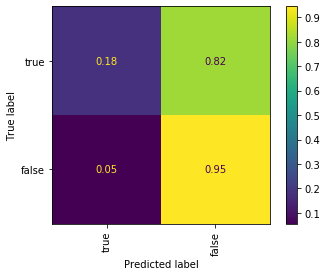

In [73]:
plot_confusion_matrix(model_rforest_2_rscv, train_X, train_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

This is basically as good as predicting 'false' all the time.

## Take 5: MNB instead of RF

According to <a href="https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf">Stanford's NLP team</a>, multinomial Naive Bayes is a good base model to use, with SVM models also a decent choice. Though this is not a NLP task (for the moment), let's plug in MNB and see what happens.

In [132]:
model_mnb = MultinomialNB()

#create a dictionary of all values we want to test for n_neighbors
param_grid_mnb = {'alpha': np.arange(0.1, 2, 0.1)}

#use gridsearch to test all values for n_neighbors
model_mnb_gscv = GridSearchCV(model_mnb, 
                              param_grid_mnb, 
                              cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), 
                              scoring=f1scorer,
                              n_jobs=6) # 6-core cpu here

In [84]:
#fit model to data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 0.30000000000000004}

In [85]:
model_mnb_gscv.best_score_

0.2092951022589793

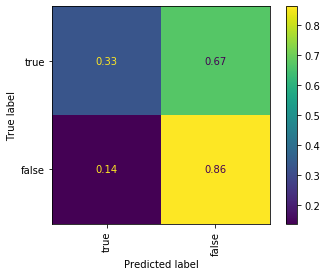

In [86]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Slightly better than RF. Check with validation:

In [346]:
speaker_aff_dummies_valid = enc.transform(liar_valid[['speaker_affiliation']].fillna(''))
speaker_aff_dummies_valid_df = pd.DataFrame(data=speaker_aff_dummies_valid, 
                                            index=liar_valid.index, 
                                            columns=enc.get_feature_names())

valid_X = speaker_aff_dummies_valid_df.join(liar_valid_subj_dummies).fillna('')

valid_y = liar_valid['label'].replace('mostly-true', 'true').replace(['half-true', 'barely-true', 'pants-fire'], 'false')

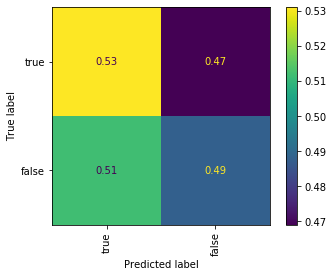

In [91]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Basically flipping a coin. Compare with dummy classifier:

In [100]:
model_dummy = DummyClassifier(random_state=RANDOM, strategy='stratified')
model_dummy.fit(train_X, train_y)

DummyClassifier(constant=None, random_state=42, strategy='stratified')

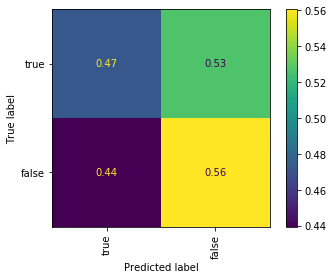

In [101]:
plot_confusion_matrix(model_dummy, train_X, train_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

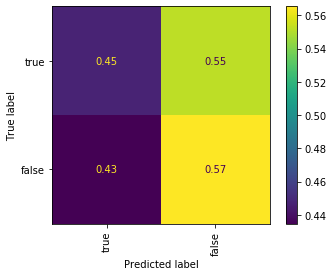

In [97]:
plot_confusion_matrix(model_dummy, valid_X, valid_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

...we see that MNB is performing worse than random chance on the validation data. Definately overfitting is happening.

Still, MNB has better performance than RF which was much more prone to overfitting.

## Take 6: Return of all features, this time with MNB

In [348]:
train_X = speaker_dummies_df.join(liar_train_subj_dummies).fillna('')
train_y = liar_train['label']

In [349]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 0.8}

In [350]:
model_mnb_gscv.best_score_

0.23323495526895294

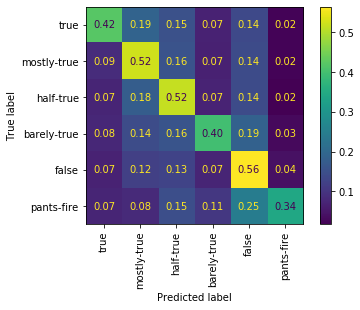

In [351]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Pretty decent performance but worse than RF; speaker attributes seem quite important! Check on validation:

In [352]:
valid_X = speaker_dummies_valid_df.join(liar_valid_subj_dummies).fillna('')
valid_y = liar_valid['label']

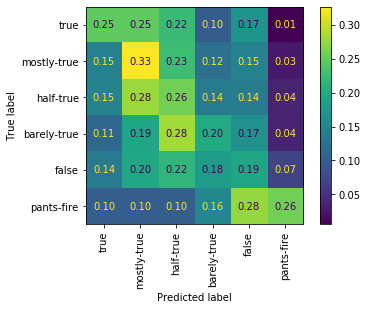

In [353]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Not half as well, overfitting taking place. Let's see if NLP will give better results.

# NLP exploration

We can work on two features: 'statement' and 'context'. Let's start with 'statement'.

## Statement

### Take 1: Words only

In [113]:
#clean the statement data

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

liar_train['statement_clean'] = liar_train.statement.map(alphanumeric).map(punc_lower)
liar_valid['statement_clean'] = liar_valid.statement.map(alphanumeric).map(punc_lower)
liar_test['statement_clean'] = liar_test.statement.map(alphanumeric).map(punc_lower)

#vectorise the words
cv1 = CountVectorizer(stop_words='english')

statement_train_cv1 = cv1.fit_transform(liar_train['statement_clean'])
statement_valid_cv1 = cv1.transform(liar_valid['statement_clean'])
statement_test_cv1  = cv1.transform(liar_test['statement_clean'])

pd.DataFrame(statement_train_cv1.toarray(), columns=cv1.get_feature_names(), index=liar_train.index)

,aa,aaa,aaron,aarp,aba,abandoned,abandoning,abbas,abbott,abc,...,zip,zippo,zombie,zombies,zone,zones,zoning,zoo,zuckerberg,zuckerbergs
id,,,,,,,,,,,,,,,,,,,,,
2635.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10540.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9028.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3408.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3959.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That's a hella lotta features!

Can words alone help predict? Try with RF first:

In [114]:
train_X = pd.DataFrame(statement_train_cv1.toarray(), columns=cv1.get_feature_names(), index=liar_train.index)
train_y = liar_train['label']

In [115]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 40, 'min_samples_split': 4, 'max_depth': 100}

In [116]:
model_rforest_rscv.best_score_

0.20813162491725445

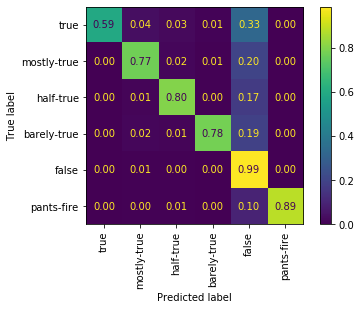

In [117]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

That *appears* decent... what about on the validation set?

In [118]:
valid_X = pd.DataFrame(statement_valid_cv1.toarray(), columns=cv1.get_feature_names(), index=liar_valid.index)
valid_y = liar_valid['label']

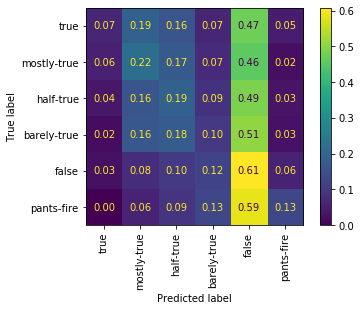

In [119]:
plot_confusion_matrix(model_rforest_rscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Overfitting like crazy; assigning the vast majority to 'false'. This is actually worse than 'subjects only'. Let's see how MNB takes it:

In [120]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 0.4}

In [121]:
model_mnb_gscv.best_score_

0.23198708309134122

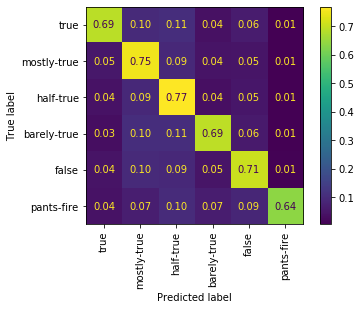

In [122]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

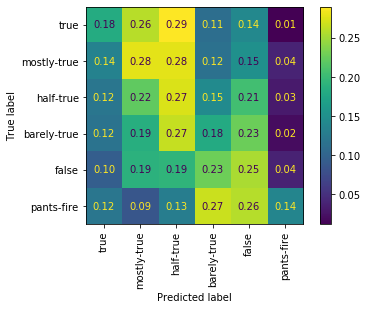

In [123]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

MNB at least doesn't predict 'false' all the time on the validation data, but performance is still not good.

### Take 2: With bigrams

In [124]:
#vectorise the words
cv2 = CountVectorizer(stop_words='english', ngram_range=(1,2))

statement_train_cv2 = cv2.fit_transform(liar_train['statement_clean'])
statement_valid_cv2  = cv2.transform(liar_valid['statement_clean'])
statement_test_cv2  = cv2.transform(liar_test['statement_clean'])

pd.DataFrame(statement_train_cv2.toarray(), columns=cv2.get_feature_names(), index=liar_train.index)

,aa,aa aaa,aaa,aaa bond,aaa credit,aaron,aaron bean,aarp,aarp endorsing,aarp inconsistently,...,zones schools,zoning,zoning control,zoning decisions,zoo,zoo county,zuckerberg,zuckerberg thirds,zuckerbergs,zuckerbergs personal
id,,,,,,,,,,,,,,,,,,,,,
2635.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10540.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9028.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3408.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3959.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That's even more features...

In [125]:
train_X = pd.DataFrame(statement_train_cv2.toarray(), columns=cv2.get_feature_names(), index=liar_train.index)
train_y = liar_train['label']

In [126]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 40, 'min_samples_split': 4, 'max_depth': 100}

In [127]:
model_rforest_rscv.best_score_

0.1761547296814729

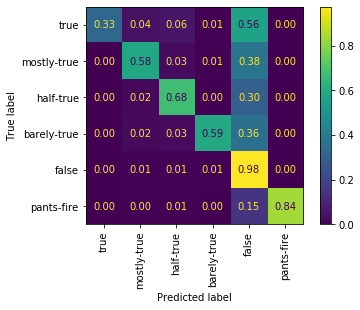

In [128]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

That *appears* decent, but note the bias towards selecting 'false'. What about on the validation set?

In [129]:
valid_X = pd.DataFrame(statement_valid_cv2.toarray(), columns=cv2.get_feature_names(), index=liar_valid.index)
valid_y = liar_valid['label']

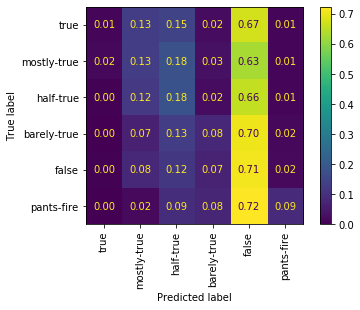

In [130]:
plot_confusion_matrix(model_rforest_rscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Overfitting like crazy; assigning the vast majority to 'false'. This is actually worse than 'subjects only'. Now it's MNB's turn.

In [133]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 0.4}

In [134]:
model_mnb_gscv.best_score_

0.23535368389021255

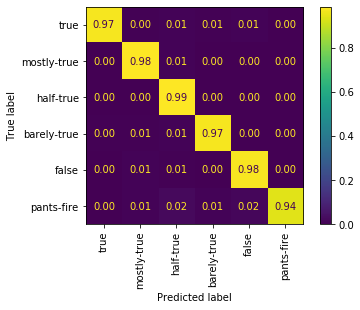

In [135]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

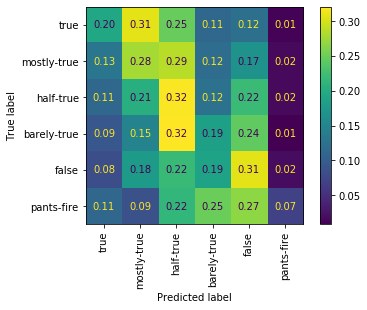

In [136]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

MNB at least doesn't predict 'false' all the time on the validation data, but performance is still not good.

Also note that at this point, memory usage and execution time are both becoming an issue. We can at least solve the former by loading in Dask; we'll do that for subsequent large training sets. We'll also drop RF as it doesn't offer clear advantages over MNB but starts to choke on massive number of features.

In [145]:
import dask.dataframe as dd
from dask.distributed import Client

client = Client()

### Take 2: TF-IDF

Let's try TF-IDF vectorizing now

In [160]:
#vectorise with TF-IDF
tv = TfidfVectorizer(stop_words='english')

statement_train_tv = tv.fit_transform(liar_train['statement_clean'])
statement_valid_tv = tv.transform(liar_valid['statement_clean'])
statement_test_tv  = tv.transform(liar_test['statement_clean'])

pd.DataFrame(statement_train_tv.toarray(), columns=tv.get_feature_names(), index=liar_train.index)

,aa,aaa,aaron,aarp,aba,abandoned,abandoning,abbas,abbott,abc,...,zip,zippo,zombie,zombies,zone,zones,zoning,zoo,zuckerberg,zuckerbergs
id,,,,,,,,,,,,,,,,,,,,,
2635.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10540.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1123.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9028.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3408.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3959.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
train_X = pd.DataFrame(statement_train_tv.toarray(), columns=tv.get_feature_names(), index=liar_train.index)
train_y = liar_train['label']

In [155]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 0.2}

In [156]:
model_mnb_gscv.best_score_

0.22060091114819516

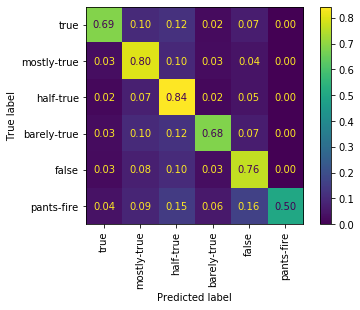

In [157]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

In [166]:
valid_X = pd.DataFrame(statement_valid_tv.toarray(), columns=tv.get_feature_names(), index=liar_valid.index)
valid_y = liar_valid['label']

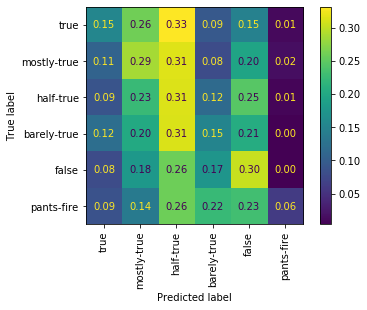

In [167]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Same deal as word vectorizer.

### Take 3: Topic modelling

Before we jump to a pre-trained GloVe model, let's see what we can do with topic modelling on what we already have.

In [203]:
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

In [287]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

First, Latent Semantic Analysis

In [223]:
vect_list = [cv1, cv2, tv]
statement_vect_list = [statement_train_cv1, statement_train_cv2, statement_train_tv]
statement_vect_names = ['Count Vect 1-gram', 'Count Vect 2-gram', 'TF-IDF Vect 1-gram']

for dictionary, name in zip(statement_vect_list, statement_vect_names):
    print(f"{name}:")
    for num_topics in range(2,101):
        lsa_model = TruncatedSVD(num_topics, random_state=RANDOM)
        lsa_topic = lsa_model.fit_transform(dictionary)
        if(max(lsa_model.explained_variance_ratio_) > 0.2):
            print(f"   {num_topics} topics - {lsa_model.explained_variance_ratio_}")
            print_top_words(lsa_model, vectorizer.get_feature_names(), 10)

Count Vect 1-gram:
Count Vect 2-gram:
TF-IDF Vect 1-gram:


The explained varience just isn't high enough to justify LSA topic modelling. 

What about non-negative factorizing?

In [221]:
for dictionary, vectorizer, name in zip(statement_vect_list, vect_list, statement_vect_names):
    print(f"{name}:")
    for num_topics in range(2,5):
        nmf_model = NMF(num_topics, random_state=RANDOM)
        nmf_topic = nmf_model.fit_transform(dictionary)
        print_top_words(nmf_model, vectorizer.get_feature_names(), 10)

Count Vect 1-gram:
Topic #0: says obama president barack said texas state voted tax clinton
Topic #1: percent health state care year tax years people json million

Topic #0: says obama president texas said barack voted clinton hillary trump
Topic #1: percent rate income unemployment tax pay taxes people year years
Topic #2: health state care json million year tax president budget obama

Topic #0: says texas voted said clinton hillary tax trump donald scott
Topic #1: percent rate income unemployment tax pay taxes people year years
Topic #2: health state care tax json million year budget true republican
Topic #3: obama president barack jobs said bush office years administration debt

Count Vect 2-gram:
Topic #0: says percent obama tax president state years jobs barack taxes
Topic #1: health care insurance law plan reform government americans coverage federal

Topic #0: percent says state tax years year taxes jobs states billion
Topic #1: health care insurance law plan reform government a

Looking at the results for TF-IDF vectorizer, the topics actually look similar to the top topics that were manually tagged in the data set, ie the economy, health care, debt and unemployment. Let's look at the top 100. 

In [318]:
nmf_model = NMF(100, random_state=RANDOM)
nmf_topic = nmf_model.fit_transform(statement_train_tv)
print_top_words(nmf_model, tv.get_feature_names(), 10)

Topic #0: says, rep, called, workers, wall, supports, oregon, marco, chris, street
Topic #1: care, health, reform, costs, coverage, takeover, mandate, provide, obamas, access
Topic #2: obama, barack, administration, wants, muslim, experience, promised, force, worked, socialist
Topic #3: percent, increased, nearly, population, wealth, gone, ninety, gdp, reduced, owns
Topic #4: jobs, create, creating, added, overseas, losing, manufacturing, industry, month, china
Topic #5: states, united, countries, combined, nations, higher, best, ranks, exports, death
Topic #6: tax, cuts, sales, breaks, corporate, increases, estate, rates, returns, dollars
Topic #7: billion, dollars, deficit, surplus, costs, fund, paid, taxpayers, spent, projected
Topic #8: state, employees, local, secretary, tuition, union, capita, employee, pensions, agencies
Topic #9: million, spent, dollars, nearly, surplus, taxpayers, poverty, got, estimated, left
Topic #10: taxes, property, raising, raised, paying, fees, higher, 

Let's see how these synthetic subject features fare! We'll also bring back the full set of speaker features

In [319]:
nmf_100topics = pd.DataFrame(nmf_topic, index=liar_train.index).add_prefix('topic_')

In [354]:
train_X = speaker_dummies_df.join(nmf_100topics).fillna('')
train_y = liar_train['label']

In [355]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 1.1}

In [356]:
model_mnb_gscv.best_score_

0.23250904734746572

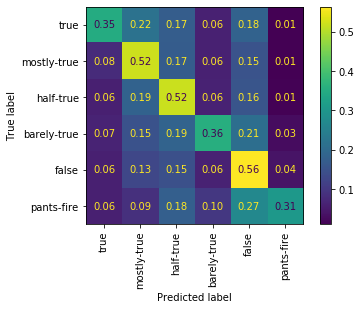

In [357]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

In [358]:
nmf_topic_valid = nmf_model.transform(statement_valid_tv)
nmf_100topics_valid = pd.DataFrame(nmf_topic_valid, index=liar_valid.index).add_prefix('topic_')
valid_X = data=speaker_dummies_valid_df.join(nmf_100topics_valid).fillna('')
valid_y = liar_valid['label']

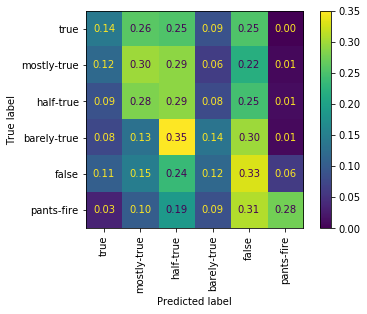

In [359]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

That's pretty bad in terms of classification. What if we limit topics to 20?

In [360]:
nmf_model = NMF(20, random_state=RANDOM)
nmf_topic = nmf_model.fit_transform(statement_train_tv)
nmf_20topics = pd.DataFrame(nmf_topic, index=liar_train.index).add_prefix('topic_')

In [361]:
train_X = speaker_dummies_df.join(nmf_20topics).fillna('')
train_y = liar_train['label']

In [362]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 1.0}

In [363]:
model_mnb_gscv.best_score_

0.23309595098448826

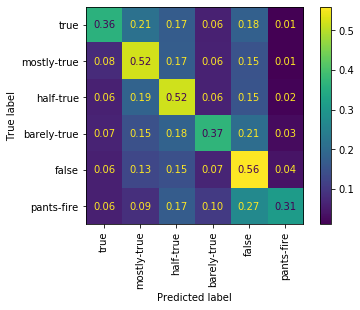

In [364]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

In [365]:
nmf_topic_valid = nmf_model.transform(statement_valid_tv)
nmf_20topics_valid = pd.DataFrame(nmf_topic_valid, index=liar_valid.index).add_prefix('topic_')
valid_X = speaker_dummies_valid_df.join(nmf_20topics_valid).fillna('')
valid_y = liar_valid['label']

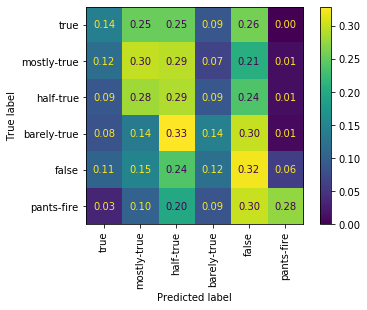

In [366]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

No discernible differences. Perhaps if we limit our target to 'true' and 'false'?

In [367]:
train_y = liar_train['label'].replace('mostly-true', 'true').replace(['half-true', 'barely-true', 'pants-fire'], 'false')
valid_y = liar_valid['label'].replace('mostly-true', 'true').replace(['half-true', 'barely-true', 'pants-fire'], 'false')

In [368]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 0.30000000000000004}

In [369]:
model_mnb_gscv.best_score_

0.6147740190870092

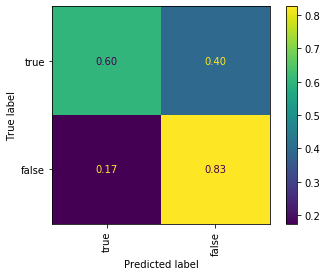

In [370]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

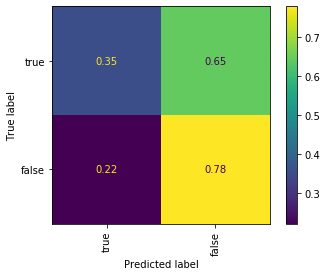

In [371]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

No better than random chance. Since we've cut down on number of features, perhaps RF will play nice?

In [372]:
#fit model to data
model_rforest_2_rscv.fit(train_X, train_y)
model_rforest_2_rscv.best_params_

{'n_estimators': 40, 'min_samples_split': 4, 'max_depth': 100}

In [373]:
model_rforest_2_rscv.best_score_

0.5910397205267343

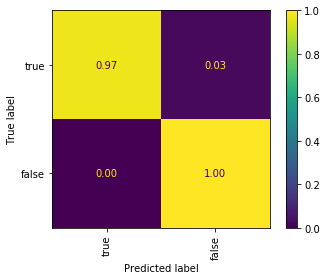

In [374]:
plot_confusion_matrix(model_rforest_2_rscv, train_X, train_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

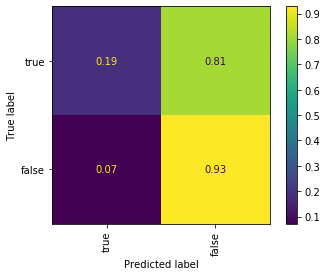

In [375]:
plot_confusion_matrix(model_rforest_2_rscv, valid_X, valid_y, 
                      labels=['true', 'false'], 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

Nope, RF has the same problems that it encountered earlier. Perhaps if we pulled context in?

## Context

Since the context blurbs are so short, let's try 2-gram TF-IDF

In [283]:
liar_train['context'].fillna('', inplace=True)
liar_valid['context'].fillna('', inplace=True)
liar_test['context'].fillna('', inplace=True)

In [382]:
liar_train['context'].value_counts()

a news release                             241
an interview                               229
a press release                            223
a speech                                   214
a TV ad                                    180
                                          ... 
an ABC-6 interview program                   1
the second GOP debate                        1
an Enterprise Florida meeting                1
the New York Sun                             1
an immigration policy speech in Phoenix      1
Name: context, Length: 4346, dtype: int64

In [383]:
liar_train['context'].value_counts().head(50)

a news release                            241
an interview                              229
a press release                           223
a speech                                  214
a TV ad                                   180
a tweet                                   156
a campaign ad                             132
a television ad                           123
a radio interview                         106
                                          102
a debate                                   92
a news conference                          85
a Facebook post                            74
a campaign commercial                      73
a television interview                     68
a press conference                         65
a speech.                                  57
a press release.                           49
a TV interview                             47
a radio ad                                 45
a chain e-mail                             41
a TV ad.                          

In [284]:
#clean the context

liar_train['context_clean'] = liar_train.context.map(alphanumeric).map(punc_lower)
liar_valid['context_clean'] = liar_valid.context.map(alphanumeric).map(punc_lower)
liar_test['context_clean'] = liar_test.context.map(alphanumeric).map(punc_lower)

#vectorise with TF-IDF
tv2 = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

context_train_tv2 = tv2.fit_transform(liar_train['context_clean'])
context_valid_tv2 = tv2.transform(liar_valid['context_clean'])
context_test_tv2  = tv2.transform(liar_test['context_clean'])

pd.DataFrame(context_train_tv2.toarray(), columns=tv2.get_feature_names(), index=liar_train.index)

,aarp,abbott,abbott texas,abc,abc good,abc interview,abc line,abc news,abc radio,abc republican,...,youtube attack,youtube campaign,youtube com,youtube debate,youtube radio,youtube video,zach,zach galifianakis,zakaria,zakaria gps
id,,,,,,,,,,,,,,,,,,,,,
2635.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10540.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1123.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9028.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3408.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3959.json,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [288]:
for num_topics in range(2,10):
    lsa_model = TruncatedSVD(num_topics, random_state=RANDOM)
    lsa_topic = lsa_model.fit_transform(context_train_tv2)
    print(f"   {num_topics} topics - {lsa_model.explained_variance_ratio_}")
    print_top_words(lsa_model, tv2.get_feature_names(), 10)

   2 topics - [0.03454888 0.03748553]
Topic #0: release, interview, press release, press, news release, news, conference, fox, radio, radio interview
Topic #1: interview, radio, radio interview, tv, ad, tv ad, tv interview, television, television interview, cnn

   3 topics - [0.03454769 0.03748718 0.03142236]
Topic #0: release, interview, press release, press, news release, news, conference, radio, radio interview, fox
Topic #1: interview, radio, radio interview, tv, ad, tv ad, tv interview, television, television interview, cnn
Topic #2: ad, tv ad, tv, campaign, campaign ad, television ad, television, speech, campaign tv, radio ad

   4 topics - [0.03454311 0.03748499 0.03141774 0.03104922]
Topic #0: release, interview, press release, press, news release, news, conference, radio, fox, radio interview
Topic #1: interview, radio, radio interview, tv, ad, tv ad, tv interview, television, television interview, cnn
Topic #2: ad, tv ad, tv, campaign, campaign ad, television ad, television,

At most a 3% variation. Let's try 50 contexts with NMF (LSA give negative values which don't play nice with MNB), combined with the NMF 20 subjects or the original subjects

In [384]:
nmf_model_context = NMF(50, random_state=RANDOM)
nmf_context = nmf_model_context.fit_transform(context_train_tv2)
nmf_50contexts = pd.DataFrame(nmf_context, index=liar_train.index).add_prefix('context_')

In [387]:
train_X = speaker_dummies_df.join([nmf_50contexts, liar_train_subj_dummies]).fillna('')
train_y = liar_train['label']

In [388]:
#fit model to new data
model_mnb_gscv.fit(train_X, train_y)
model_mnb_gscv.best_params_

{'alpha': 1.1}

In [389]:
model_mnb_gscv.best_score_

0.23436933001818777

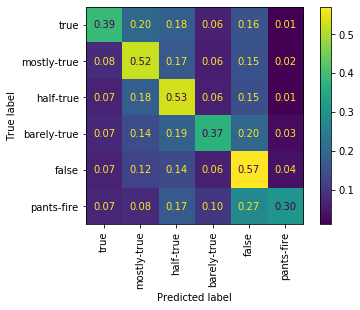

In [390]:
plot_confusion_matrix(model_mnb_gscv, train_X, train_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

In [393]:
nmf_context_valid = nmf_model_context.transform(context_valid_tv2)
nmf_50contexts_valid = pd.DataFrame(nmf_context_valid, index=liar_valid.index).add_prefix('context_')

valid_X = speaker_dummies_valid_df.join([nmf_50contexts_valid, liar_valid_subj_dummies]).fillna('')
valid_y = liar_valid['label']

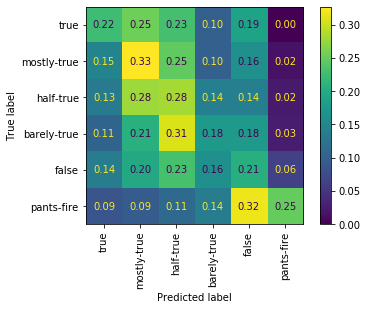

In [394]:
plot_confusion_matrix(model_mnb_gscv, valid_X, valid_y, 
                      labels=liar_label_order, 
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f');

### Take 3: Stanford's GloVe

The whole pretrained model (using the Common Crawl dataset) is ~5.5GB

In [168]:
glove_file = './data/glove.840B.300d.txt'
tmp_file = './data/glovetmp.txt'

if not os.path.isfile(tmp_file):
    _ = glove2word2vec(glove_file, tmp_file)

glove_model = KeyedVectors.load_word2vec_format(tmp_file)

C:\Users\vi_ci\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Take 2: Stanford Stanza features

In [169]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

C:\Users\vi_ci\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vi_ci\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vi_ci\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vi_ci\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Found GPU at: /device:GPU:0


In [170]:
import stanza
stanza.download('en')       # This downloads the English models for the neural pipeline

2020-06-06 17:34:25 INFO: Downloading default packages for language: en (English)...
2020-06-06 17:34:27 INFO: File exists: C:\Users\vi_ci\stanza_resources\en\default.zip.
2020-06-06 17:34:31 INFO: Finished downloading models and saved to C:\Users\vi_ci\stanza_resources.


In [171]:
nlp = stanza.Pipeline('en', use_gpu=True, verbose=True, pos_batch_size=3000)
doc = nlp("Barack Obama was born in Hawaii.  He was elected president in 2008.")
doc.sentences[0].print_dependencies()

2020-06-06 17:34:31 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| ner       | ontonotes |

2020-06-06 17:34:31 INFO: Use device: cpu
2020-06-06 17:34:31 INFO: Loading: tokenize
2020-06-06 17:34:31 INFO: Loading: pos
2020-06-06 17:34:32 INFO: Loading: lemma
2020-06-06 17:34:32 INFO: Loading: depparse
2020-06-06 17:34:33 INFO: Loading: ner
2020-06-06 17:34:34 INFO: Done loading processors!


('Barack', '4', 'nsubj:pass')
('Obama', '1', 'flat')
('was', '4', 'aux:pass')
('born', '0', 'root')
('in', '6', 'case')
('Hawaii', '4', 'obl')
('.', '4', 'punct')


In [ ]:
if os.path.isfile('data/statement.stanza'):
    statement_stanza = load('data/statement.stanza')
    dump(statement_stanza, 'data/statement.stanza')
else:
    statement_stanza = liar_train['statement'].apply(nlp)

In [ ]:
if os.path.isfile('data/statement_comb.stanza'):
    statement_comb_stanza = load('data/statement_comb.stanza')
    dump(statement_comb_stanza, 'data/statement_comb.stanza')
else:
    statement_comb_stanza = nlp('\n\n'.join(liar_train['statement']))

In [ ]:
stnlp.extract_pos(statement_comb_stanza)

~211k features! 

In [ ]:
stnlp.extract_lemma(statement_comb_stanza)['lemma'].value_counts()

Condensing to lemmas, we get ~11k features. Note the huge number of stop words and punctuation at the top of the ranks; let's remove those

In [ ]:
stnlp.extract_pos(statement_comb_stanza)['pos'].value_counts()